# Multitask Plots

## Imports

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
!pip install -r /content/drive/MyDrive/Google_Colab/requirements.txt

In [15]:
%cd /content/drive/MyDrive/Google_Colab

/content/drive/MyDrive/Google_Colab


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

import qsttoolkit as qst

## Data Preparation

In [21]:
data = qst.data.optical_state_dataset(dim=32,
                                      data_dim=32,
                                      state_numbers=[1000, 1000, 1000, 1000, 1000, 1000, 0, 1000],       # Large numbers of GKP states take an intractable amount of time to produce, and are difficult to produce practically
                                      mixed_state_noise_level = 0.2,
                                      Gaussian_conv_ntherm = 2.0,
                                      affine_theta = 20.0,
                                      affine_x = 0.1,
                                      affine_y = 0.1,
                                      additive_Gaussian_stddev = 0.001,
                                      pepper_p = 0.01,
                                      salt_p = 0.0)

/content/drive/MyDrive/Google_Colab/qsttoolkit/data/state_batches.py:170: UserWarning: thermal states are currently initialized as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.
  warnings.warn("thermal states are currently initialized as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.")
/content/drive/MyDrive/Google_Colab/qsttoolkit/data/state_batches.py:365: UserWarning: Random states are currently initialized as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the future.
  warnings.warn("Random states are currently initialized as density matrices. Calling the product of the .density_matrices() method is equivalent to simply calling .states() attribute. This may change in the 

States generated
DataFrames initialized
Fock data generated
Coherent data generated
Thermal data generated
Num data generated
Binomial data generated
Cat data generated
GKP data generated
Random data generated
Dataset generated


In [22]:
data.head()

,label,density_matrix,Husimi-Q_function,state_parameter
0,coherent,"[[(0.7469266696342314+0j), (0.1807633864088582...","[[0.008342214824282759, 0.009111621958094342, ...",0.244420-0.125670j
1,coherent,"[[(0.007237830492782839+0j), (-0.0017705606925...","[[0.009786655285978612, 0.008040330843426017, ...",-0.383840-2.907482j
2,binomial,"[[(0.11920325802989405+0j), (-0.00052307813424...","[[0.00872904471637004, 0.010190620928950785, 0...",3.000000+0.000000j
3,coherent,"[[(0.007137178473844236+0j), (-0.0005340148231...","[[0.00975568053806002, 0.008358218756797221, 0...",-0.526320-2.465860j
4,num,"[[(0.20999210048305247+0j), (-0.03416943571081...","[[0.010914998038143199, 0.010517052501119579, ...",4.335775+0.000000j


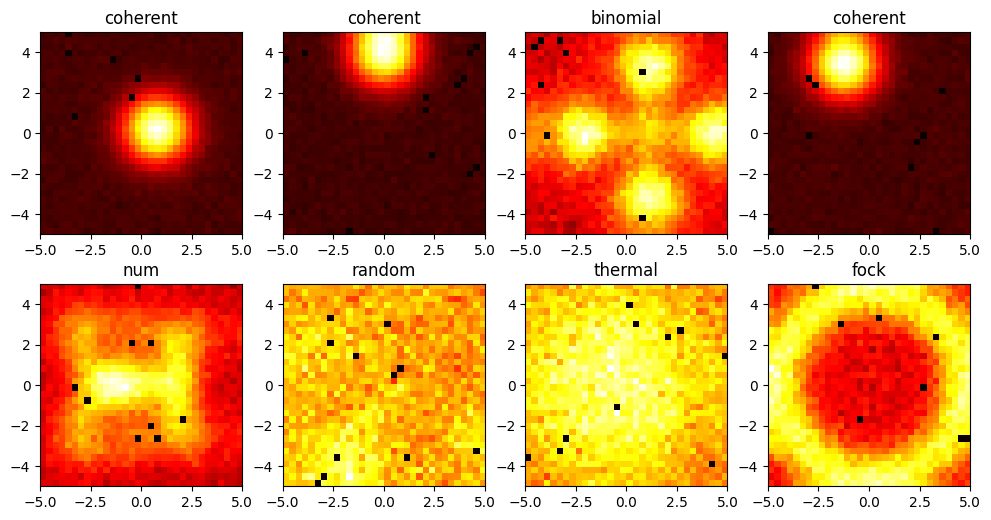

In [23]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
axs[0,0].imshow(data['Husimi-Q_function'][0], extent=[-5,5,-5,5], cmap='hot')
axs[0,0].set_title(data['label'][0])
axs[0,1].imshow(data['Husimi-Q_function'][1], extent=[-5,5,-5,5], cmap='hot')
axs[0,1].set_title(data['label'][1])
axs[0,2].imshow(data['Husimi-Q_function'][2], extent=[-5,5,-5,5], cmap='hot')
axs[0,2].set_title(data['label'][2])
axs[0,3].imshow(data['Husimi-Q_function'][3], extent=[-5,5,-5,5], cmap='hot')
axs[0,3].set_title(data['label'][3])
axs[1,0].imshow(data['Husimi-Q_function'][4], extent=[-5,5,-5,5], cmap='hot')
axs[1,0].set_title(data['label'][4])
axs[1,1].imshow(data['Husimi-Q_function'][5], extent=[-5,5,-5,5], cmap='hot')
axs[1,1].set_title(data['label'][5])
axs[1,2].imshow(data['Husimi-Q_function'][6], extent=[-5,5,-5,5], cmap='hot')
axs[1,2].set_title(data['label'][6])
axs[1,3].imshow(data['Husimi-Q_function'][7], extent=[-5,5,-5,5], cmap='hot')
axs[1,3].set_title(data['label'][7])
plt.show()

## Modelling

In [24]:
X = data['Husimi-Q_function']

y_class_raw = data['label']
label_encoder = LabelEncoder()
y_class_int = label_encoder.fit_transform(y_class_raw)

y_reg_real = data['state_parameter'].apply(lambda x: x.real)
y_reg_imag = data['state_parameter'].apply(lambda x: x.imag)
y_reg = np.array([y_reg_real, y_reg_imag]).T

X_train, X_test, y_train_class, y_test_class, y_train_reg, y_test_reg, indices_train, indices_test = train_test_split(X, y_class_int, y_reg, range(len(X)), test_size=0.2, random_state=42)

# Dictionaries to handle both regression and classification tasks
y_train = {"classification_output": y_train_class, "regression_output": y_train_reg}
y_test = {"classification_output": y_test_class, "regression_output": y_test_reg}
data_dim = X_train[0].shape[0]
X_train = np.array([x for x in X_train]).reshape(-1, data_dim, data_dim, 1)
X_test = np.array([x for x in X_test]).reshape(-1, data_dim, data_dim, 1)

In [25]:
multitask_model = qst.tomography.MultitaskQuantumStateTomography(X_train=X_train,
                                                                 X_test=X_test,
                                                                 y_train=y_train,
                                                                 y_test=y_test,
                                                                 label_encoder=label_encoder,
                                                                 early_stopping_patience=50,
                                                                 lr_scheduler_factor=0.5,
                                                                 lr_scheduler_patience=15)

In [26]:
multitask_model.train(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999),
                      classification_loss='sparse_categorical_crossentropy',
                      regression_loss='mse',
                      classification_loss_weight=1.0,
                      regression_loss_weight=1.0,
                      classification_metric='accuracy',
                      regression_metric='mse',
                      epochs=200,
                      batch_size=32,
                      validation_split=0.2,
                      verbose='auto')

Epoch 1/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 28s 47ms/step - classification_output_accuracy: 0.1574 - classification_output_loss: 2.0184 - loss: 43.0665 - regression_output_loss: 41.0482 - regression_output_mse: 41.0482 - val_classification_output_accuracy: 0.1259 - val_classification_output_loss: 3.4472 - val_loss: 53.1806 - val_regression_output_loss: 49.7334 - val_regression_output_mse: 49.7334 - learning_rate: 5.0000e-04
Epoch 2/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - classification_output_accuracy: 0.4370 - classification_output_loss: 1.5525 - loss: 30.7963 - regression_output_loss: 29.2438 - regression_output_mse: 29.2438 - val_classification_output_accuracy: 0.3482 - val_classification_output_loss: 3.0263 - val_loss: 44.2928 - val_regression_output_loss: 41.2665 - val_regression_output_mse: 41.2665 - learning_rate: 5.0000e-04
Epoch 3/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - classification_output_accuracy: 0.5960 - classification_output_loss: 1.3794 - loss: 24.7668 - 

## Analysis and Evaluation

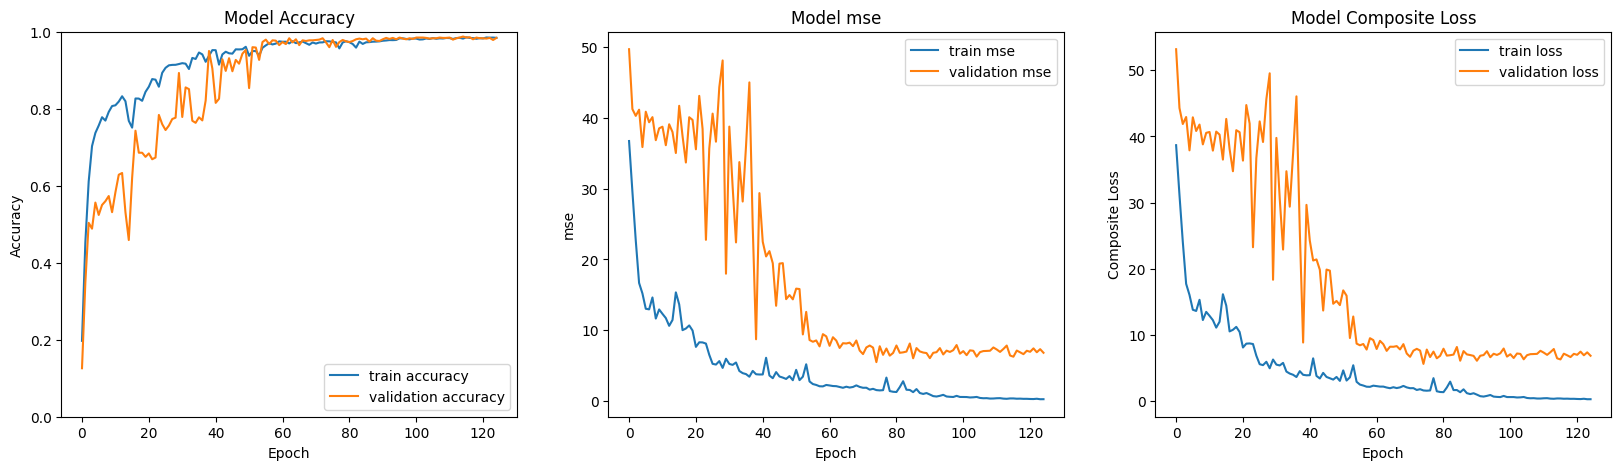

In [27]:
multitask_model.plot_training()

44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step


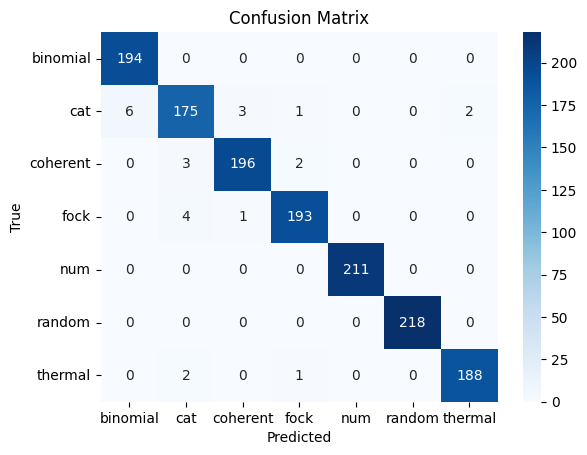

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       194
           1       0.95      0.94      0.94       187
           2       0.98      0.98      0.98       201
           3       0.98      0.97      0.98       198
           4       1.00      1.00      1.00       211
           5       1.00      1.00      1.00       218
           6       0.99      0.98      0.99       191

    accuracy                           0.98      1400
   macro avg       0.98      0.98      0.98      1400
weighted avg       0.98      0.98      0.98      1400



In [28]:
multitask_model.evaluate_classification(include_confusion_matrix=True, include_classification_report=True)

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


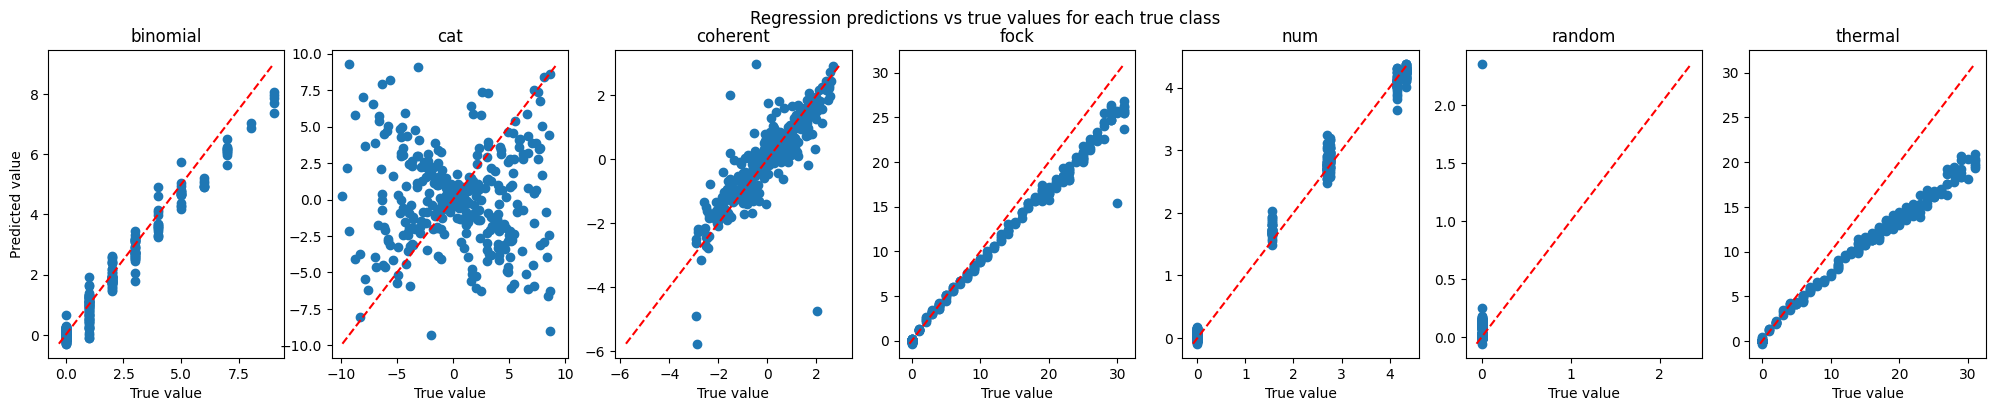

In [29]:
multitask_model.evaluate_regression()

## Reconstructing Density Matrices from Inferred Labels and Parameters

In [32]:
reconstructor = qst.tomography.StateReconstructor()

predicted_labels, predicted_state_parameters = multitask_model.infer(X_test)

reconstructor.add_data(true_labels = label_encoder.inverse_transform(y_test['classification_output']),
                       predicted_labels = predicted_labels,
                       true_state_parameters = y_test['regression_output'],
                       predicted_state_parameters = predicted_state_parameters,
                       true_dms = data['density_matrix'].iloc[indices_test].reset_index(drop=True))

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [33]:
reconstructor.restrict_parameters(fock_n_range=[0,31], binomial_S_range=[1,10])

In [34]:
reconstructor.predictions_df.head()

,true_label,predicted_label,true_state_parameter,predicted_state_parameter,restricted_predicted_state_parameter,true_dm,reconstructed_dm,fidelity
0,binomial,binomial,2.000000,2.540229+0.139474j,3.000000+0.000000j,"[[(0.12143045028365416+0j), (-0.00034180171144...",NaN,NaN
1,binomial,binomial,3.000000,3.132625+0.134296j,3.000000+0.000000j,"[[(0.012631024645864216+0j), (-0.0010049412834...",NaN,NaN
2,cat,cat,-8.791239,-4.092066+0.371511j,-4.092066+0.371511j,"[[(0.007802311446732762+0j), (0.00017863963749...",NaN,NaN
3,random,random,0.000000,0.114590+0.013083j,0.114590+0.013083j,"[[(0.03488391044670555+0j), (0.000834457148070...",NaN,NaN
4,num,num,4.335775,4.288237+0.009697j,4.335775+0.000000j,"[[(0.21098496083036758+0j), (-0.03302182744761...",NaN,NaN


In [35]:
reconstructor.reconstruct()

In [36]:
reconstructor.predictions_df.head()

,true_label,predicted_label,true_state_parameter,predicted_state_parameter,restricted_predicted_state_parameter,true_dm,reconstructed_dm,fidelity
0,binomial,binomial,2.000000,2.540229+0.139474j,3.000000+0.000000j,"[[(0.12143045028365416+0j), (-0.00034180171144...","Quantum object: dims=[[32], [32]], shape=(32, ...",NaN
1,binomial,binomial,3.000000,3.132625+0.134296j,3.000000+0.000000j,"[[(0.012631024645864216+0j), (-0.0010049412834...","Quantum object: dims=[[32], [32]], shape=(32, ...",NaN
2,cat,cat,-8.791239,-4.092066+0.371511j,-4.092066+0.371511j,"[[(0.007802311446732762+0j), (0.00017863963749...","Quantum object: dims=[[32], [32]], shape=(32, ...",NaN
3,random,random,0.000000,0.114590+0.013083j,0.114590+0.013083j,"[[(0.03488391044670555+0j), (0.000834457148070...","Quantum object: dims=[[32], [32]], shape=(32, ...",NaN
4,num,num,4.335775,4.288237+0.009697j,4.335775+0.000000j,"[[(0.21098496083036758+0j), (-0.03302182744761...","Quantum object: dims=[[32], [32]], shape=(32, ...",NaN


In [37]:
reconstructor.calculate_fidelities()

Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to find a square root.
Failed to 

In [38]:
reconstructor.predictions_df.fidelity.mean()

0.5000617725647463301

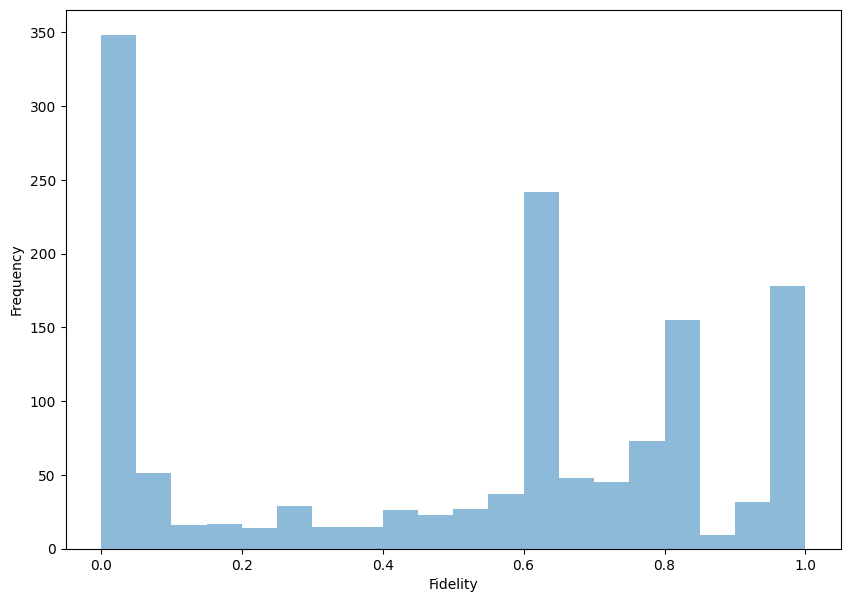

In [39]:
reconstructor.plot_fidelities(color_by_true_label=False)

In [42]:
fidelity_distribution = pd.DataFrame({'fidelities': reconstructor.predictions_df.fidelity})
fidelity_distribution.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   fidelities  1400 non-null   float128
dtypes: float128(1)
memory usage: 22.0 KB


In [43]:
fidelity_distribution.to_csv('Multitask_fidelity_dist.csv')